In [6]:
import numpy as np
import matplotlib.pyplot as plt
import lot
from scipy.stats import norm

In [2]:
#Hyperparameters
N = [200,220]

# Minimal value (avoid zeros)
v_min = 0.02

# First distribution
mu0 = 0.3
std0 = 0.05

mu1 = 0.7
std1 = 0.06

X = np.arange(N[0]) / N[0]
a = norm.pdf(X, loc=mu0, scale=std0)
a += norm.pdf(X, loc=mu1, scale=std1)
a = (a + v_min * a.max())
a = a / a.sum()

# Second distribution
mu2= 0.6
std2= 0.06

mu3 = 0.4
std3 = 0.05

Y = np.arange(N[1]) / N[1]
b = norm.pdf(Y, loc=mu2, scale=std2)
b += norm.pdf(Y, loc=mu3, scale=std3)
b = (b + v_min * b.max())
b = b / b.sum()

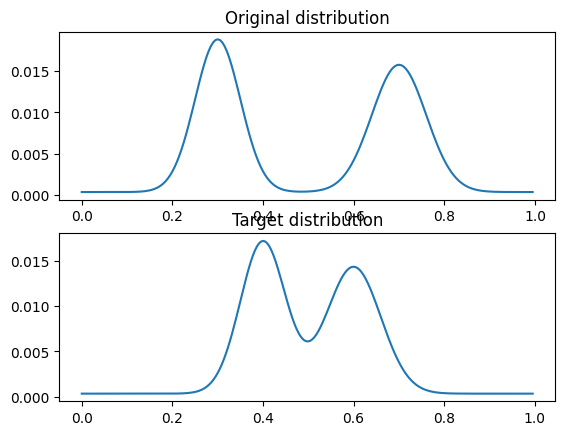

In [3]:
plt.figure()
plt.subplot(211)
plt.title("Original distribution")
plt.plot(X, a)
plt.subplot(212)
plt.title("Target distribution")
plt.plot(Y, b)
plt.show()

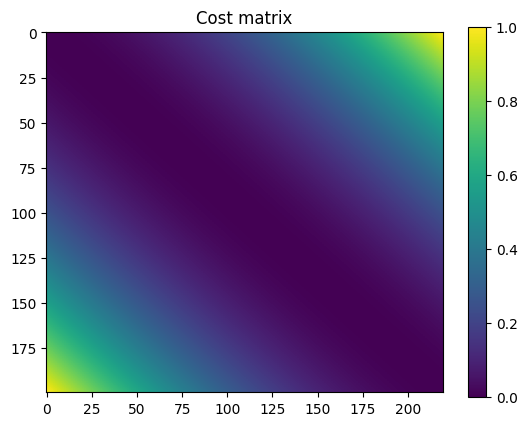

In [5]:
# Get the cost matrix
C = np.abs(X[:, None] - Y[None, :]) ** 2
C /= C.max()

plt.figure()
plt.title("Cost matrix")
plt.imshow(C)
plt.colorbar()
plt.show()

# Sinkhorn algorithm

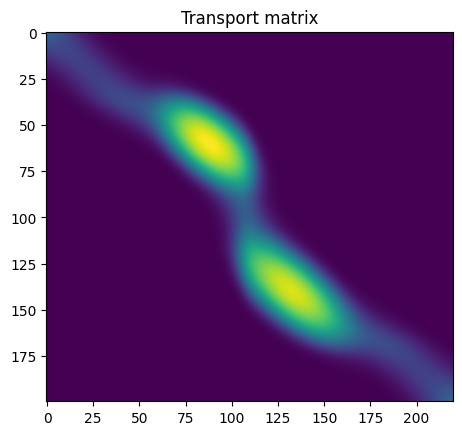

In [7]:
epsilon = 0.005

P, err_p, err_q, times, cost = lot.sinkhorn(a, b, C, epsilon, max_time=5)

plt.figure()
plt.title("Transport matrix")
plt.imshow(np.log(P+ 1e-5))
plt.show()

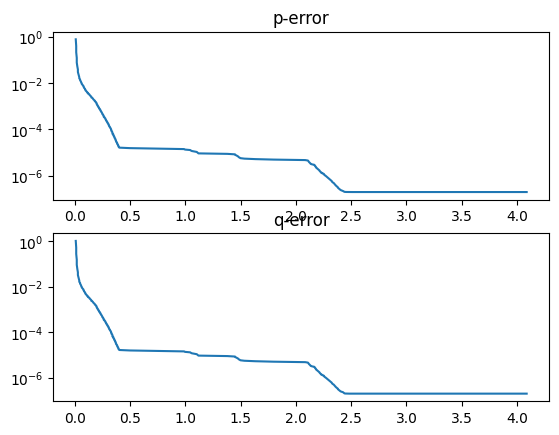

In [9]:
# Show convergence
plt.figure()
plt.subplot(211)
plt.title("p-error")
plt.plot(times, err_p)
plt.semilogy()

plt.subplot(212)
plt.title("q-error")
plt.plot(times, err_q)
plt.semilogy()
plt.show()

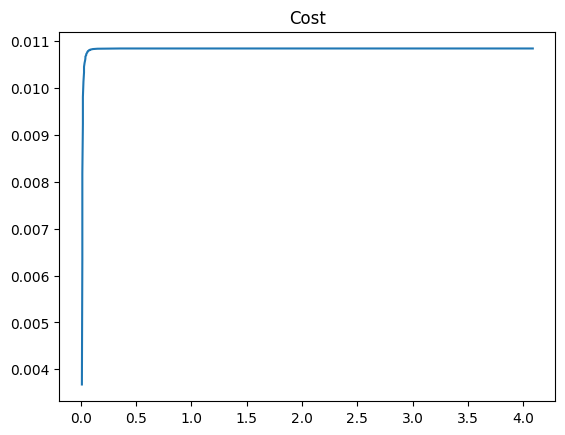

In [10]:
plt.figure()
plt.title("Cost")
plt.plot(times, cost)
plt.show()

In [12]:
## Compute the couplings obtained by Sinkhorn algorithm for multiple regularizations
P_Sin = []
epsilon_list = [0.001, 0.005, 0.05, 0.5]

for epsilon in epsilon_list:
    P, _, _, _, _ = lot.sinkhorn(
        a, b, C, epsilon, max_iter=100, delta=1e-9, lbd=0, max_time=50
    )
    P_Sin.append(P)

# Low-rank Method

In [17]:
## Compute the couplings obtained by LOT for multiple ranks
P_LOT = []
rank_list = [3, 10, 50, 100]

epsilon=0
alpha=1e-10
gamma=10
max_iter=1000
delta=1e-3
max_time=50
max_iter_dykstra=10000
delta_dykstra=1e-3
lbd_dykstra=0

for rank in rank_list:
    _, _, _, Q, R, g = lot.low_rank_ot(
        a, b, rank, C,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    P = Q / g @ R.T
    P_LOT.append(P)

C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: divide by zero encountered in log
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))
C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: invalid value encountered in multiply
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))


Break: criterion is nan at iter  169
Break: criterion is nan at iter  142
Break: criterion is nan at iter  114
Break: criterion is nan at iter  104


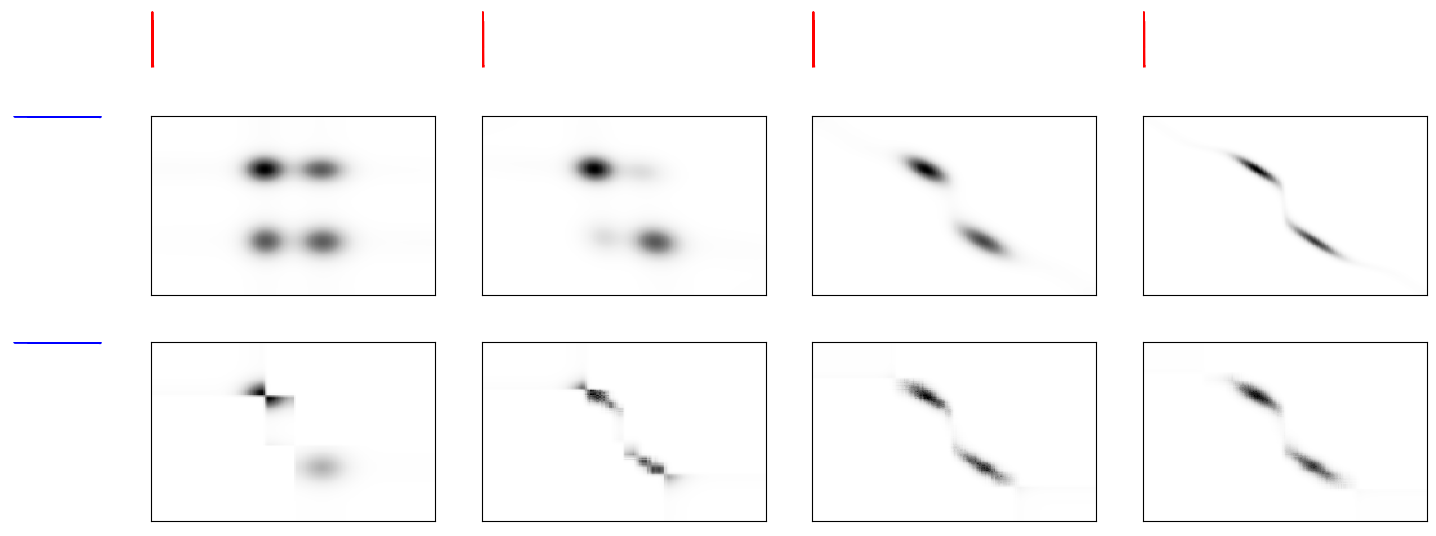

In [18]:
## Plot the comparison of couplings
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
widths = [1, 3, 3, 3, 3]  # ncols
heights = [1, 3, 3]  # nrows
gs = fig.add_gridspec(nrows=3, ncols=5, width_ratios=widths, height_ratios=heights)


f_ax1 = fig.add_subplot(gs[1, 0])
f_ax1.plot(a, X, "b", label="Source distribution")
f_ax1.axes.xaxis.set_visible(False)
plt.gca().invert_xaxis()
plt.axis("off")

f_ax2 = fig.add_subplot(gs[2, 0])
f_ax2.plot(a, X, "b", label="Source distribution")
f_ax2.axes.xaxis.set_visible(False)
plt.gca().invert_xaxis()
plt.axis("off")


for k in range(len(P_Sin)):

    f_ax3 = fig.add_subplot(gs[0, k + 1])
    f_ax3.plot(Y, b, "r", label="Target distribution")
    f_ax3.axes.xaxis.set_visible(False)
    plt.axis("off")

    num_Sin = len(P_Sin)
    if k == 0:
        f_ax4 = fig.add_subplot(gs[1, k + 1], sharex=f_ax3, sharey=f_ax1)
        f_ax4.imshow(
            P_Sin[-1 - k], interpolation="nearest", cmap="Greys", aspect="auto"
        )

        f_ax5 = fig.add_subplot(gs[2, k + 1], sharey=f_ax2)
        f_ax5.imshow(
            P_LOT[k], interpolation="nearest", cmap="Greys", aspect="auto"
        )
    else:
        f_ax4 = fig.add_subplot(gs[1, k + 1], sharex=f_ax3)
        f_ax4.imshow(
            P_Sin[-1 - k], interpolation="nearest", cmap="Greys", aspect="auto"
        )

        f_ax5 = fig.add_subplot(gs[2, k + 1])
        f_ax5.imshow(
            P_LOT[k], interpolation="nearest", cmap="Greys", aspect="auto"
        )

    f_ax4.set_xticks([])
    f_ax4.set_yticks([])

    f_ax5.set_xticks([])
    f_ax5.set_yticks([])

fig.tight_layout(pad=3.0)
# fig.savefig("plot_coupling.pdf", bbox_inches="tight")
plt.show()

# Linear LOT

In [19]:
## Compute the couplings obtained by LOT for multiple ranks
P_LOT = []
rank_list = [3, 10, 50, 100]

epsilon=0
alpha=1e-10
gamma=10
max_iter=1000
delta=1e-3
max_time=50
max_iter_dykstra=10000
delta_dykstra=1e-3
lbd_dykstra=0

# Get factorized cost matrices
p = np.power(X, 2)
q = np.power(Y, 2)
C1 = np.vstack((p, np.ones_like(p), -2 * X.T)).T
C2 = np.vstack((np.ones_like(q), q, Y.T)).T

for rank in rank_list:
    _, _, _, Q, R, g = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    P = Q / g @ R.T
    P_LOT.append(P)

C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: divide by zero encountered in log
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))
C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: invalid value encountered in multiply
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))


Break: criterion is nan at iter  167
Break: criterion is nan at iter  143
Break: criterion is nan at iter  116
Break: criterion is nan at iter  106


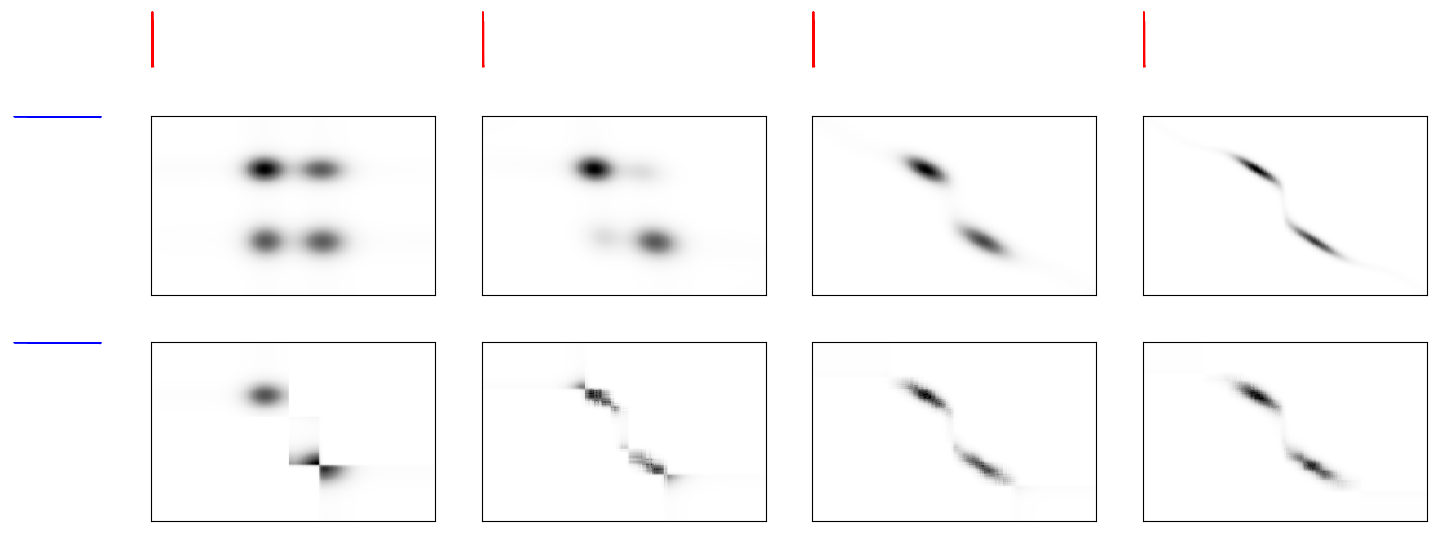

In [20]:
## Plot the comparison of couplings
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
widths = [1, 3, 3, 3, 3]  # ncols
heights = [1, 3, 3]  # nrows
gs = fig.add_gridspec(nrows=3, ncols=5, width_ratios=widths, height_ratios=heights)


f_ax1 = fig.add_subplot(gs[1, 0])
f_ax1.plot(a, X, "b", label="Source distribution")
f_ax1.axes.xaxis.set_visible(False)
plt.gca().invert_xaxis()
plt.axis("off")

f_ax2 = fig.add_subplot(gs[2, 0])
f_ax2.plot(a, X, "b", label="Source distribution")
f_ax2.axes.xaxis.set_visible(False)
plt.gca().invert_xaxis()
plt.axis("off")


for k in range(len(P_Sin)):

    f_ax3 = fig.add_subplot(gs[0, k + 1])
    f_ax3.plot(Y, b, "r", label="Target distribution")
    f_ax3.axes.xaxis.set_visible(False)
    plt.axis("off")

    num_Sin = len(P_Sin)
    if k == 0:
        f_ax4 = fig.add_subplot(gs[1, k + 1], sharex=f_ax3, sharey=f_ax1)
        f_ax4.imshow(
            P_Sin[-1 - k], interpolation="nearest", cmap="Greys", aspect="auto"
        )

        f_ax5 = fig.add_subplot(gs[2, k + 1], sharey=f_ax2)
        f_ax5.imshow(
            P_LOT[k], interpolation="nearest", cmap="Greys", aspect="auto"
        )
    else:
        f_ax4 = fig.add_subplot(gs[1, k + 1], sharex=f_ax3)
        f_ax4.imshow(
            P_Sin[-1 - k], interpolation="nearest", cmap="Greys", aspect="auto"
        )

        f_ax5 = fig.add_subplot(gs[2, k + 1])
        f_ax5.imshow(
            P_LOT[k], interpolation="nearest", cmap="Greys", aspect="auto"
        )

    f_ax4.set_xticks([])
    f_ax4.set_yticks([])

    f_ax5.set_xticks([])
    f_ax5.set_yticks([])

fig.tight_layout(pad=3.0)
# fig.savefig("plot_coupling.pdf", bbox_inches="tight")
plt.show()

# Gaussian data

In [21]:
# Generate gaussian data
N = [5000, 5000]
X = np.random.normal(loc=1, scale=1, size=(N[0], 2))
Y = np.random.normal(loc=0, scale=0.1, size=(N[1], 2))

# Compute cost matrices
p = np.power(np.linalg.norm(X, axis=-1, ord=2), 2)
q = np.power(np.linalg.norm(Y, axis=-1, ord=2), 2)

C = np.linalg.norm(X[:, None] - Y[None, :], axis=-1, ord=2) ** 2
C1 = np.vstack((p, np.ones_like(p), -2 * X.T)).T
C2 = np.vstack((np.ones_like(q), q, Y.T)).T

# Uniform distributions
a = np.ones(N[0]) / N[0]
b = np.ones(N[1]) / N[1]

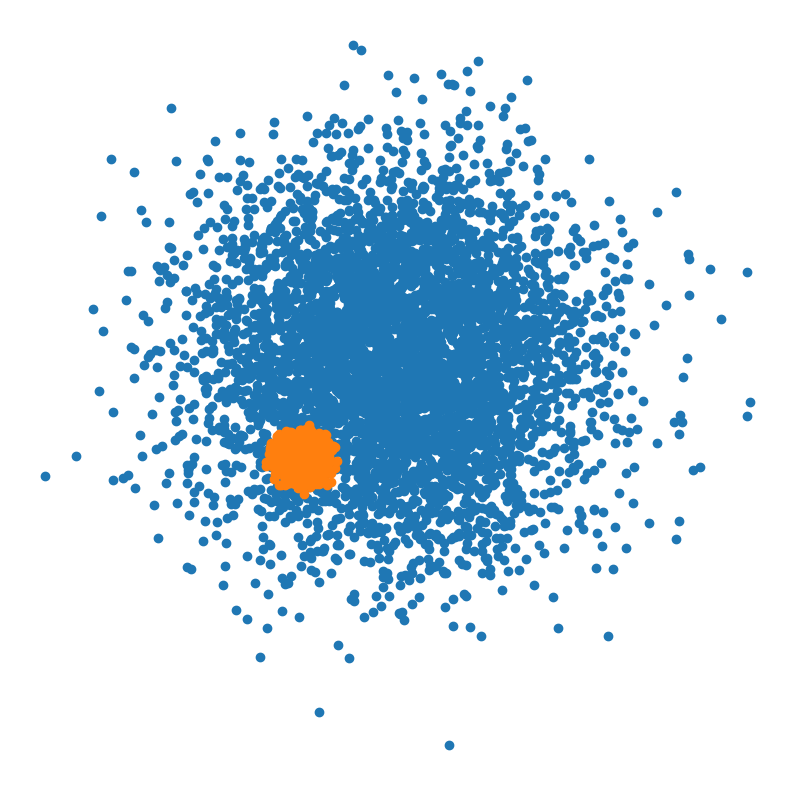

In [22]:
# Display the clouds
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:, 1])
plt.scatter(Y[:,0], Y[:, 1])
plt.axis("off")
plt.show()

In [36]:
epsilon = 0.01
max_time=100
alpha=1e-5
gamma_0 = 5
delta = 1e-5

# Sinkhorn
_, _, _, times_sin, cost_sin = lot.sinkhorn(a, b, C, epsilon=epsilon, max_time=max_time)

rank_list = [10, 50, 100, 300]
cost_lot = []
times_lot = []

for rank in rank_list:
    print(f"Rank {rank}:", end=" ")
    _, cost, times, _, _, _ = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma_0,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    cost_lot.append(cost)
    times_lot.append(times)
    print("done")
print()
# Now for the un-penalized method
epsilon = 0

cost_lot_sec = []
times_lot_sec = []

for rank in rank_list:
    print(f"Rank {rank}:", end=" ")
    _, cost, times, _, _, _ = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma_0,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    cost_lot_sec.append(cost)
    times_lot_sec.append(times)
    print("done")

Rank 10: done
Rank 50: done
Rank 100: done
Rank 300: done

Rank 10: done
Rank 50: done
Rank 100: done
Rank 300: done


[]

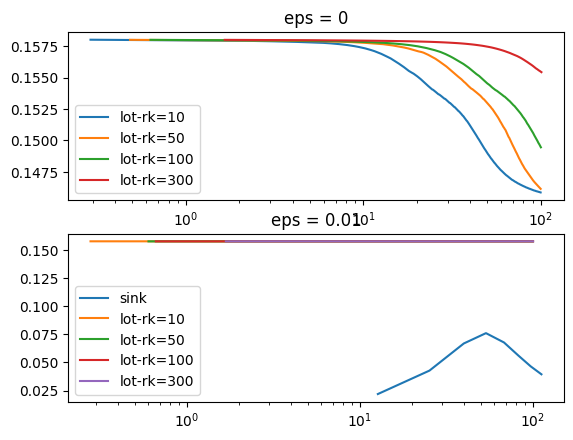

In [40]:
plt.figure()
plt.subplot(211)
plt.title("eps = 0")
for i in range(len(rank_list)):
    rank = rank_list[i]
    plt.plot(times_lot_sec[i], cost_lot_sec[i], label=f"lot-rk={rank}")
plt.legend(loc="best")
plt.semilogx()

plt.subplot(212)
plt.title("eps = 0.01")
plt.plot(times_sin, cost_sin, label="sink")
for i in range(len(rank_list)):
    rank = rank_list[i]
    plt.plot(times_lot[i], cost_lot[i], label=f"lot-rk={rank}")
plt.legend(loc="best")
plt.semilogx()